In [1]:
import itertools
import json
import re
import sys
from pathlib import Path

import pandas as pd
import numpy as np
from tqdm import tqdm 

import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.stats.proportion import proportions_ztest

from scipy.stats import pearsonr, spearmanr, mannwhitneyu

In [2]:
def load_json(path):
    with open(path) as infile:
        return json.load(infile)

def save_json(obj, path):
    with open(path, 'w') as outfile:
        return json.dump(obj, outfile, indent=2)

In [3]:
DATA_DIR = "../data/human/all_data"
DATA_FILE = "all_data.csv"
FILTER_ON_FAMILIARITY = False
DROP_NA = False # if true, then nan/inf set to 0
AVERAGE_ANNOTATIONS = False # average over human annotators before running regression
ITERS = 1_000

## Data compilation

In [4]:
auto_metric_names = [
 'c_npmi_10_full',
 'c_npmi_10_nytimes_full',
 'c_npmi_10_test',
 'c_npmi_10_train',
 'c_npmi_10_val',
 'c_npmi_10_wikitext_full',
 'c_uci_full',
 'c_v_full',
 'c_v_nytimes_full',
 'c_v_test',
 'c_v_train',
 'c_v_val',
 'c_v_wikitext_full',
 'u_mass_full'
]

In [5]:
task_data = pd.read_csv(Path(DATA_DIR, DATA_FILE))

In [6]:
# complete the out-of-sample columns
for dataset in ["wikitext", "nytimes"]:
    for metric in ["c_npmi_10", "c_v"]:
        task_data[f"{metric}_{dataset}_full"] = task_data[f"{metric}_{dataset}_full"].combine_first(task_data[f"{metric}_full"])

In [7]:
# add the constant for lin. reg
task_data = sm.add_constant(task_data)

In [8]:
# convert infinite values to nans
task_data = task_data.replace(np.inf, np.nan)

In [12]:
if FILTER_ON_FAMILIARITY:
    task_data = task_data.loc[task_data.confidences_raw == 1]

## Regression 

Assess variances by topic. This may help determine if averaging is ok

/workspace/.conda/envs/topic-preprocessing/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([<AxesSubplot:title={'center':'intrusions'}>,
       <AxesSubplot:title={'center':'ratings'}>], dtype=object)

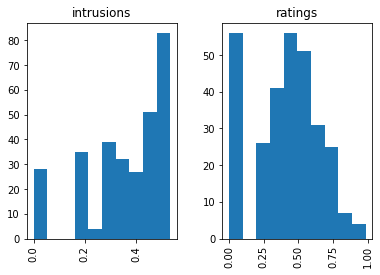

In [13]:
topic_stds = task_data.groupby(['task', 'dataset', 'model', 'topic_idx']).agg({"scores_raw": "std"}).reset_index()
topic_stds["scores_raw"].hist(by=topic_stds["task"])

 First, simple linear regression (ignoring model effects)

In [25]:
AVERAGE_ANNOTATIONS = False
FILTER_ON_FAMILIARITY = False
DROP_NA = False
USE_OLS = True
ALPHA = 0.05
np.random.seed(42)
rows = []
for task in ["ratings", "intrusions"]:
    for dataset in ["wikitext", "nytimes", "all"]:
        data_df = task_data.loc[task_data.task == task]
        if dataset != "all":
            data_df = data_df.loc[data_df.dataset == dataset]
        if FILTER_ON_FAMILIARITY:
            data_df = data_df.loc[data_df.confidences_raw == 1]

        # run regressions for each metric
        for i, metric in enumerate(auto_metric_names):
            #print(f"\n===={task}, {dataset}, {metric}====\n")
            if dataset in metric:
                continue # don't re-do the internal
            if DROP_NA:
                df = data_df.dropna(subset=[metric])
            else:
                df = data_df.fillna(0)
            if AVERAGE_ANNOTATIONS:
                df = df.groupby(["model", "topic_idx"]).mean().reset_index()
                mod = sm.OLS(df["scores_raw"], df[["const", metric]])
            if USE_OLS:
                scores = df["scores_raw"] if task == "intrusions" else (df["scores_raw"] - 1) / 2
                mod = sm.OLS(scores, df[["const", metric]])
            elif task == "intrusions":
                mod = sm.Logit(df["scores_raw"], df[["const", metric]])
            elif task == "ratings":
                mod = OrderedModel(df["scores_raw"], df[[metric]], distr="probit")
            res = mod.fit(disp=0)
            metric_base = re.search("c_npmi_10|c_v|c_uci|u_mass", metric).group(0)
            ci_lb, ci_ub = res.conf_int(alpha=ALPHA).loc[metric] 
            row = {
                "task": task,
                "dataset": dataset,
                "metric": metric_base,
                "reference": metric.replace(f"{metric_base}_", ""),
                "coef": res.params[metric],
                "se": res.bse[metric],
                "p": res.pvalues[metric],
                "bic": res.bic,
                "ci_0.025": ci_lb,
                "ci_0.975": ci_ub,
            }
            rows.append(row)
regressions = pd.DataFrame(rows)

In [319]:
if not FILTER_ON_FAMILIARITY and not AVERAGE_ANNOTATIONS:
    regressions.to_csv("regression_results.csv", index=False)

### Make the latex table

We want to bold the values that are significantly larger than others using the CIs

In [26]:
def find_max_coefs(coefs, lbs, ubs, contiguous=False):
    n = len(coefs)
    coefs = np.nan_to_num(coefs, nan=0)
    lbs = np.nan_to_num(lbs, nan=0)
    ubs = np.nan_to_num(ubs, nan=0)
    sorted_coef_idx = np.argsort(coefs)[::-1]
    for i, idx in enumerate(sorted_coef_idx[1:], start=1):
        # is the upper bound of this coefficient contained in the
        # lower bound of the next-largest coefficient?
        prev_idx = sorted_coef_idx[i-1] if contiguous else sorted_coef_idx[0]
        if ubs[idx] < lbs[prev_idx]:
            return np.array([j in sorted_coef_idx[:i] for j in range(n)])
    return np.full(n, True)

In [27]:
METRICS_TO_KEEP = ["c_v", "c_npmi_10"]
regressions.loc[(regressions.dataset=="wikitext") & (regressions.reference == "full"), "reference"] = "wikitext_full"
regressions.loc[(regressions.dataset=="nytimes") & (regressions.reference == "full"), "reference"] = "nytimes_full"
regressions_pivot = (
    regressions.loc[regressions.metric.isin(METRICS_TO_KEEP)]
               .replace({""})
               .sort_values(["task", "dataset", "metric", "reference"])
               #.pivot(index=["Metric", "Reference"], columns=["Task", "Dataset"], values="coef")
               .pivot(index=["task", "dataset"], columns=["metric", "reference"], values=["coef", "ci_0.025", "ci_0.975"])
)
# order the columns
regressions_pivot = regressions_pivot[[
    (v, m, r)
    for v in ["coef", "ci_0.025", "ci_0.975"]
    for m in ["c_npmi_10", "c_v"]
    for r in ["nytimes_full", "wikitext_full", "train", "val"] #NB: test excluded
]]

In [28]:
# bold format the significant values
for idx, row in regressions_pivot.iterrows():
    max_coefs = find_max_coefs(row['coef'], row["ci_0.025"], row["ci_0.975"])
    newrow = []
    for i, x in enumerate(row["coef"]):
        if np.isnan(x):
            val = "-"
        elif not np.isnan(x) and max_coefs[i]:
            val = r"\uline{" + f"{x:0.2f}" + "}"
            if x == np.max(row['coef']):
                val = r"\textbf{" + val + "}"
        else:
            val = f"{x:0.2f}"
        newrow.append(val)
    regressions_pivot.at[idx, "coef"] = newrow

In [29]:
# make latex
regressions_pivot_coefs = regressions_pivot["coef"].loc[[
    ('intrusions',  'nytimes'),
    ('intrusions', 'wikitext'),
    ('intrusions',      'all'),
    (   'ratings',  'nytimes'),
    (   'ratings', 'wikitext'),
    (   'ratings',      'all'),
]]
latex = regressions_pivot_coefs.to_latex(escape=False, multicolumn_format='c', column_format="ll|rrrr|rrrr")
to_replace_in_latex={
    "c_v": r"$C_v$ (110-token window)",
    "test": "Test",
    "c_npmi_10": r"\abr{npmi} (10-token window)",
    "nytimes_full": r"\abr{nyt}",
    "wikitext_full": r"\abr{wiki}",
    "wikitext": r"\abr{wiki}",
    "nytimes": r"\abr{nyt}",
    "all": "Both",
    "full": "Full",
    "train": "Train",
    "val": "Val",
    "ratings": "Rating",
    "intrusions": "Intrusion",
    "metric": "",
    "dataset": r"Train Corpus $\downarrow$",
    "reference": r"Ref. Corpus $\rightarrow$",
    "task": "",
}
for to_replace, val in to_replace_in_latex.items():
    latex = latex.replace(to_replace, val)
print(latex)


\begin{tabular}{ll|rrrr|rrrr}
\toprule
        &  & \multicolumn{4}{c}{\abr{npmi} (10-token window)} & \multicolumn{4}{c}{$C_v$ (110-token window)} \\
        & Ref. Corpus $\rightarrow$ &  \abr{nyt} &          \abr{wiki} &                  Train &   Val &  \abr{nyt} & \abr{wiki} &                  Train &           Val \\
 & Train Corpus $\downarrow$ &               &                        &                        &       &               &               &                        &               \\
\midrule
Intrusion & \abr{nyt} &          0.47 &  \textbf{\uline{0.72}} &                   0.41 &  0.39 &  \uline{0.53} &  \uline{0.66} &           \uline{0.54} &          0.50 \\
        & \abr{wiki} &  \uline{0.75} &           \uline{0.94} &  \textbf{\uline{1.02}} &  0.17 &          0.44 &          0.56 &                   0.56 &          0.14 \\
        & Both &          0.53 &  \textbf{\uline{0.80}} &                   0.59 &  0.16 &          0.47 &          0.62 &                   0.5

Linear regression with model effects

Linear regression with familiarity effect

Best explanation of data

## Prediction Setup

In [37]:
def create_split(task_data, test_size):
    topic_sample = (
    task_data.groupby(["task", "dataset", "model", "topic_idx"])
                .size()
                .reset_index()
                .groupby(["task", "dataset", "model"])
                .sample(frac=test_size)
                .drop(columns=0)
    )
    topic_sample
    task_data["idx"] = np.arange(len(task_data))
    task_data_train = task_data.merge(topic_sample, how='inner')
    task_data_test = task_data.loc[~task_data.idx.isin(task_data_train.idx)]
    return task_data_train, task_data_test

def random_choice_prob_index(a, axis=1):
    # basically vectorized categorical draw https://stackoverflow.com/a/47722393
    r = np.expand_dims(np.random.rand(a.shape[1-axis]), axis=axis)
    return (a.cumsum(axis=axis) > r).argmax(axis=axis)

def fit_predict_intrusion(train_df, test_df):
    exog_cols = ["const", metric]
    mod = sm.Logit(train_df["scores_raw"], train_df[exog_cols])
    res = mod.fit(disp=0)
    return res.model.predict(res.params, exog=test_df[exog_cols])

def fit_predict_ratings(train_df, test_df):
    exog_cols = [metric]
    mod = OrderedModel(train_df["scores_raw"], train_df[exog_cols], distr="probit")
    res = mod.fit(disp=0)
    return res.model.predict(res.params, exog=test_df[exog_cols])

def intrusion_test(scores_a, scores_b, alternative="larger"):
    return proportions_ztest(
        [scores_a.sum(), scores_b.sum()],
        [len(scores_a), len(scores_b)],
        alternative=alternative
    )

def ratings_test(scores_a, scores_b, alternative="greater"):
    return mannwhitneyu(scores_a, scores_b, alternative=alternative)

def false_discovery_rate_sim(
    task,
    test_df,
    probs,
    metric,
    n_iters=100,
    alpha=0.05,
    models=["mallet", "dvae", "etm"],
):
    false_positives, false_negatives = 0, 0
    discoveries, omissions = 0, 0
    total = 0
    if task == "intrusions":
        stat_test = intrusion_test
    elif task == "ratings":
        stat_test = ratings_test

    for i in range(n_iters):
        # sample pseduo human scores
        if task == "intrusions":
            preds = np.random.binomial(1, p=probs)
        elif task == "ratings":
            preds = random_choice_prob_index(probs)

        # Calculate the false discovery rate
        # TODO: is one-sided appropriate here? does this affect division?
        for model_a, model_b in itertools.permutations(models, 2):
            model_a_idxr = test_df.model==model_a
            model_b_idxr = test_df.model==model_b
            # run the tests for both human and auto metrics
            stat_auto, p_auto = stat_test(preds[model_a_idxr], preds[model_b_idxr])
            stat_human, p_human = stat_test(test_df.loc[model_a_idxr]["scores_raw"], test_df.loc[model_b_idxr]["scores_raw"])

            if p_auto < alpha: # auto rejects the null
                false_positives += p_human > alpha # human fails to reject the null
                discoveries += 1
            if p_human < alpha: # human rejects the null
                false_negatives += p_auto > alpha # auto fails to reject null
                omissions += 1
            total += 1
    false_pos_rate = np.nan if discoveries == 0 else false_positives / discoveries
    false_neg_rate = np.nan if omissions == 0 else false_negatives / omissions
    return false_pos_rate, false_neg_rate, (total - (false_positives + false_negatives)) / total

In [38]:
GLOBAL_ITERS = 5
LOCAL_ITERS = 10
TEST_SIZE = 0.5
AVERAGE_ANNOTATIONS = False
FILTER_ON_FAMILIARITY = False
DROP_NA = False
ALPHA = 0.05
NUM_ANNOTATORS = {"intrusions": 26, "ratings": 15}
METRICS_TO_USE = [
 'c_npmi_10_full',
 'c_npmi_10_nytimes_full',
 'c_npmi_10_test',
 'c_npmi_10_train',
 'c_npmi_10_val',
 'c_npmi_10_wikitext_full',
 'c_v_full',
 'c_v_nytimes_full',
 'c_v_test',
 'c_v_train',
 'c_v_val',
 'c_v_wikitext_full',
]

In [39]:
if not DROP_NA:
    task_data = task_data.fillna(0)

In [40]:

rows = []
np.random.seed(42)
for iteration in tqdm(range(GLOBAL_ITERS), total=GLOBAL_ITERS):
    # iterate through variants and estimate models
    task_data_train, task_data_test = create_split(task_data, TEST_SIZE)
    
    for task in ["intrusions", "ratings"]:
        for dataset in ["wikitext", "nytimes", "all"]:
            train_df = task_data_train.loc[task_data_train.task == task]
            test_df = task_data_test.loc[task_data_test.task == task]

            if dataset != "all":
                train_df = train_df.loc[train_df.dataset == dataset]
                test_df = test_df.loc[test_df.dataset == dataset]
            if FILTER_ON_FAMILIARITY:
                train_df = train_df.loc[train_df.confidences_raw == 1]
                test_df = test_df.loc[test_df.confidences_raw == 1]

            for i, metric in enumerate(METRICS_TO_USE):
                # estimate a model for the metric, then make predictions
                if dataset in metric:
                    continue # don't re-do the internal
                elif task == "intrusions":
                    probs = fit_predict_intrusion(train_df, test_df)
                elif task == "ratings":
                    probs = fit_predict_ratings(train_df, test_df)
                fp_rate, fn_rate, agree_rate = false_discovery_rate_sim(
                    task, test_df, probs, metric, n_iters=LOCAL_ITERS, alpha=ALPHA
                )
                metric_base = re.search("c_npmi_10|c_v|c_uci|u_mass", metric).group(0)
                row = {
                    "iter": iteration,
                    "task": task,
                    "dataset": dataset,
                    "metric": metric_base,
                    "reference": metric.replace(f"{metric_base}_", ""),
                    "false_discoveries": fp_rate,
                    "false_omissions": fn_rate,
                    "agree_rate": agree_rate, 
                }
                rows.append(row)
simulation_results = pd.DataFrame(rows)

  0%|          | 0/5 [00:00<?, ?it/s]/workspace/.conda/envs/statsmodels-dev/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:379: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
100%|██████████| 5/5 [00:44<00:00,  8.93s/it]


In [45]:
simulation_results.to_csv("simulation_results.csv")

In [44]:
simulation_results.groupby(["task", "dataset", "metric", "reference"])[["false_discoveries", "false_omissions"]].agg("mean", "std")

false_discoveries  \
task       dataset  metric    reference                          
intrusions all      c_npmi_10 full                    0.333810   
                              nytimes_full            0.308392   
                              test                    0.266747   
                              train                   0.287500   
                              val                     0.666667   
                              wikitext_full           0.344678   
                    c_v       full                    0.297537   
                              nytimes_full            0.298087   
                              test                    0.300347   
                              train                   0.293372   
                              val                     0.908333   
                              wikitext_full           0.281786   
           nytimes  c_npmi_10 full                    0.322222   
                              test                    0.293669   
                              train                   0.248571   
                              val                     0.377778   
                              wikitext_full           0.273241   
                    c_v       full                    0.295402   
                              test                    0.302069   
                              train                   0.293841   
                              val                     0.283480   
                              wikitext_full           0.284848   
           wikitext c_npmi_10 full                    0.610784   
                              nytimes_full            0.598758   
                              test                    0.625926   
                              train                   0.594118   
                              val                     0.933333   
                    c_v       full                    0.622134   
                              nytimes_full            0.604762   
                              test                    0.609091   
                              train                   0.618182   
                              val                     0.977778   
ratings    all      c_npmi_10 full                    0.475649   
                              nytimes_full            0.494543   
                              test                    0.515060   
                              train                   0.446285   
                              val                     0.225000   
                              wikitext_full           0.521446   
                    c_v       full                    0.424542   
                              nytimes_full            0.445055   
                              test                    0.416420   
                              train                   0.447801   
                              val                     0.257329   
                              wikitext_full           0.467317   
           nytimes  c_npmi_10 full                    0.724389   
                              test                    0.725859   
                              train                   0.758521   
                              val                     0.673636   
                              wikitext_full           0.740217   
                    c_v       full                    0.705097   
                              test                    0.658079   
                              train                   0.646256   
                              val                     0.626958   
                              wikitext_full           0.753879   
           wikitext c_npmi_10 full                    0.397143   
                              nytimes_full            0.443666   
                              test                    0.383458   
                              train                   0.347826   
                              val                     0.441392   
                   